# Tranfer Learning Part 1: Feature Extraction

In [1]:
# Are we using a GPU?
!nvidia-smi

Sun Nov 14 18:00:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We can use parameters trained through a different model by someone else to get great results for one of our own networks

[Tensorflow hub](https://tfhub.dev/) is a good place to find trained models

In [2]:
# DL the data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-14 18:00:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.152.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2021-11-14 18:00:23 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f' there are {len(dirnames)} directories and {len(filenames)} images in ({dirpath})')

 there are 2 directories and 0 images in (10_food_classes_10_percent)
 there are 10 directories and 0 images in (10_food_classes_10_percent/train)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/hamburger)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/grilled_salmon)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/pizza)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/ramen)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/sushi)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/steak)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/chicken_wings)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/chicken_curry)
 there are 0 directories and 75 images in (10_food_classes_10_percent/train/fried_rice)
 there are 0 directories and 75 images in (10_food_classes_10_percent/tr

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('training images:')
train_data_10 = train_datagen.flow_from_directory(train_dir, 
                                                  target_size = IMAGE_SHAPE,
                                                  batch_size = BATCH_SIZE, 
                                                  class_mode = 'categorical')
print('testing images: ')
test_data_10 = test_datagen.flow_from_directory(test_dir, 
                                                target_size = IMAGE_SHAPE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical')


training images:
Found 750 images belonging to 10 classes.
testing images: 
Found 2500 images belonging to 10 classes.


## Setting up Callbacks (things to run while the model trains)

* extra functionality you can add to your models to be performed during or after training


In [5]:
# create a tensorboard callback (functionalized to create one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, exp_name):
  log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving TensorBoeard log fils to {log_dir}')
  return tensorboard_callback


## What is this doing?

We are tracking when we run our experiments by adding the date and time the function is run into a directory named

`[dir_name]/[experiment_name]/[current_timestamp]`

* dir_name is the overall logs directory
* experiment_name is the particular experiment
* current_timestamp is the time the experiment started based on Python's datetime.datetime().now()


## Creating models using TensorFlow Hub

We are gonna use 2 models from TF Hub:
* ResNetV2 - a state of the art computer vision model architecture from 2016.

* EfficientNet - a state of the art computer vision architecture from 2019.

### Finding these models with TF Hub

1. Go to [tfhub](https://tfhub.dev/)

1. Choose your problem domain, e.g. "Image" (we're using food images).
1. Select your TF version, which in our case is TF2.
1. Remove all "Problem domanin" filters except for the problem you're working on.
  * **Note:** "Image feature vector" can be used alongside almost any problem, we'll get to this soon.

1. The models listed are all models which could potentially be used for your problem.


State of the art models can be found with [paperswithcode.com](https://paperswithcode.com/)

This can make choosing easier

In [6]:
# diving in
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# URL's from the two top of the line models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [7]:
def create_model(url, num_classes = 10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): number of output neurons, equal to the num of target classes,

  returns: uncompiled Sequential model with the url models architecture
  '''
  # DL pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(url, trainable=False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,))
  # trainable=False freezes the underlying model patterns
  model = tf.keras.Sequential([
           feature_extractor_layer,
           layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')                   
  ])
  return model

Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

In [8]:
# create model
resnet_model = create_model(resnet_url, num_classes=train_data_10.num_classes)

In [9]:
# compile
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

### What does our model look like?

All architecture and params from the OG resnet model are frozen besides the Dense layer we added

In [10]:
resnet_history = resnet_model.fit(train_data_10,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10),
                                  validation_data = test_data_10,
                                  validation_steps = len(test_data_10),
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub", exp_name = "resnet50V2")])
                    

saving TensorBoeard log fils to tensorflow_hub/resnet50V2/20211114-180040
Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 2.0244 - accuracy: 0.3213 - val_loss: 1.2811 - val_accuracy: 0.5912
Epoch 2/5
24/24 [==============================] - 21s 917ms/step - loss: 0.9264 - accuracy: 0.7240 - val_loss: 0.8837 - val_accuracy: 0.7228
Epoch 3/5
24/24 [==============================] - 21s 914ms/step - loss: 0.6386 - accuracy: 0.8147 - val_loss: 0.7701 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 21s 911ms/step - loss: 0.4979 - accuracy: 0.8627 - val_loss: 0.7155 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 21s 916ms/step - loss: 0.3976 - accuracy: 0.9040 - val_loss: 0.6857 - val_accuracy: 0.7800


This did MUCH better than my own model with only 10 percent of the data, wowza

In [11]:

# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

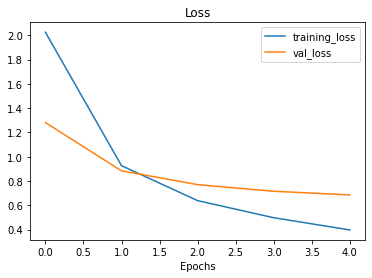

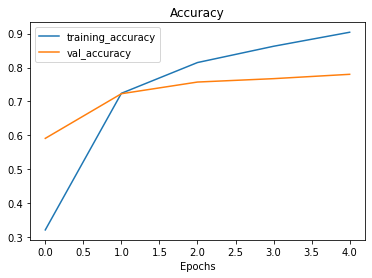

In [12]:
plot_loss_curves(resnet_history)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
# Now try the efficientnet jawn
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])
efficientnet_history = efficientnet_model.fit(train_data_10, 
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10),
                                              validation_data = test_data_10,
                                              validation_steps = len(test_data_10),
                                              callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub", exp_name = "efficientnetB0")])


saving TensorBoeard log fils to tensorflow_hub/efficientnetB0/20211114-181556
Epoch 1/5
24/24 [==============================] - 32s 897ms/step - loss: 1.8095 - accuracy: 0.4467 - val_loss: 1.2892 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 20s 837ms/step - loss: 1.0349 - accuracy: 0.7827 - val_loss: 0.8665 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 19s 833ms/step - loss: 0.7460 - accuracy: 0.8387 - val_loss: 0.7013 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.5997 - accuracy: 0.8613 - val_loss: 0.6195 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 20s 838ms/step - loss: 0.5100 - accuracy: 0.8840 - val_loss: 0.5647 - val_accuracy: 0.8588


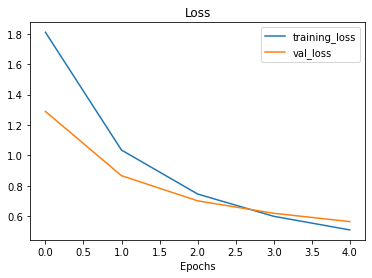

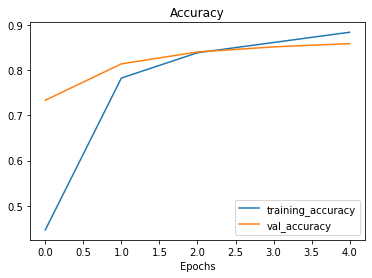

In [19]:
plot_loss_curves(efficientnet_history)

In [39]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing Models Using TensorBoard

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.

To accomplish this, use the following command:



```
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
```



Where:

* --logdir is the target upload directory
* --name is the name of the experiment
* --description is a brief description of the experiment
* --one_shot exits the TensorBoard uploader once uploading is finished

In [31]:
!tensorboard dev --help

usage: tensorboard dev [-h] [--helpfull] [--origin ORIGIN]
                       [--api_endpoint API_ENDPOINT]
                       [--grpc_creds_type {local,ssl,ssl_dev}]
                       [--auth_force_console]
                       {upload,update-metadata,delete,list,export,auth} ...

positional arguments:
  {upload,update-metadata,delete,list,export,auth}
    upload              upload an experiment to TensorBoard.dev
    update-metadata     change the name, description, or other user metadata
                        associated with an experiment.
    delete              permanently delete an experiment
    list                list previously uploaded experiments
    export              download all your experiment data
    auth                log in, log out

optional arguments:
  -h, --help            show this help message and exit
  --helpfull            show full help message and exit
  --origin ORIGIN       Experimental. Origin for TensorBoard.dev service to
        

In [38]:
import os
cwd = os.getcwd()
cwd

'/content'

In [40]:
load_ext tensorboard

In [44]:
# upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/5rKCYZkKS5imk2fVjZtBJw/

[2021-11-14T19:12:14] Started scanning logdir.
[2021-11-14T19:12:17] Total uploaded: 75 scalars, 0 tensors, 3 binary objects (9.5 MB)
[2021-11-14T19:12:17] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/5rKCYZkKS5imk2fVjZtBJw/


In [24]:

# Check out experiments
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=LqW32DOtY2O3RrhZ23xKm6egPb1s7X&prompt=consent&access_type=offline
Enter the authorization c

## Listing experiments saved to tensorboard

In [45]:
!tensorboard dev list

https://tensorboard.dev/experiment/5rKCYZkKS5imk2fVjZtBJw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   5rKCYZkKS5imk2fVjZtBJw
	Created              2021-11-14 19:12:14 (8 minutes ago)
	Updated              2021-11-14 19:12:17 (8 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              75
	Tensor bytes         0
	Binary object bytes  9995104
Total: 1 experiment(s)


In [ ]:
## Deleting TensorBoard Experiments

In [ ]:
# !tensorboard dev delete --experiment_id 5rKCYZkKS5imk2fVjZtBJw
